In [1]:
%%capture
%cd ..

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from typing import Callable
from celluloid import Camera
from modules.derivatives import second_derivative_4
from multiprocessing import Pool
from os import cpu_count
cpu_count()

8

In [48]:
from dataclasses import dataclass
from collections.abc import Callable

@dataclass
class HProblem1D:
    dt: float
    dx: float
    L:  float
    f:  Callable
    g:  Callable
    x0: float=0
    u:  float=1
    left_free:  bool=False
    right_free: bool=False
    h:  Callable=None

    def __post_init__(self):
        self.N = int((self.L - self.x0)/self.dx)
        self.x = np.linspace(self.x0, self.L, self.N)
        f = self.f(self.x)
        self._Y = [f[1:-1]]
        self._Y.append(
            f[1:-1] + self.dt*self.g(self.x[1:-1]) + (self.dt**2/2)*(self.get_h(0) + self.u**2*second_derivative_4(f, self.dx))
        )
        self._t = [0, self.dt]
        self._f0 = self.f(self.x0)
        self._fL = self.f(self.L)

    def _get_alpha(self, i):
        return self._f0 if not self.left_free else self._Y[i][0]
    
    def _get_beta(self, i):
        return self._fL if not self.right_free else self._Y[i][-1]
    
    @property
    def y(self):
        return np.r_[self._get_alpha(-1), self._Y[-1], self._get_beta(-1)]
    
    @property
    def t(self):
        return np.stack(self._t)
    
    @property
    def Y(self):
        return np.stack([
            np.r_[
                self._get_alpha(i), 
                self._Y[i], 
                self._get_beta(i),
            ] 
            for i in range(len(self._Y))
        ])
    
    @property
    def b(self):
        return np.r_[self._get_alpha(-1), np.zeros(self.N-4), self._get_beta(-1)]
    
    def get_h(self, i):
        if self.h == None:
            return 0
        else:
            return self.h(self._t[i], self.x[1:-1], self._Y[i])
    
    def get_grid_extents(self):
        return self.x.min(), self.x.max(), self.t.min(), self.t.max()
    
    def run(self, steps: int):
        for _ in range(steps):
            self.step()

class Wave1D(HProblem1D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.lamb = (self.u*self.dt/self.dx)**2
        self.LAMB = 2*(1 - self.lamb)*np.identity(self.N-2) + self.lamb*(np.diagflat(np.ones(self.N-3), 1) + np.diagflat(np.ones(self.N-3), -1))
    
    def step(self):
        self._Y.append(self.LAMB.dot(self._Y[-1]) - self._Y[-2] + self.lamb*self.b + self.dt**2*self.get_h(-1))
        self._t.append(self._t[-1] + self.dt)

In [27]:
def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

In [45]:
wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    L= 1,
    f= (lambda x: np.sin(np.pi*x)),
    g= (lambda x: 0),
    u= 1
)

camera = Camera(plt.gcf())
for _ in range(500):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

In [33]:
wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    L= 10,
    f= (lambda x: np.exp(-x**2)),
    g= (lambda x: 0),
    u= 2,
    left_free= True
)

camera = Camera(plt.gcf())
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

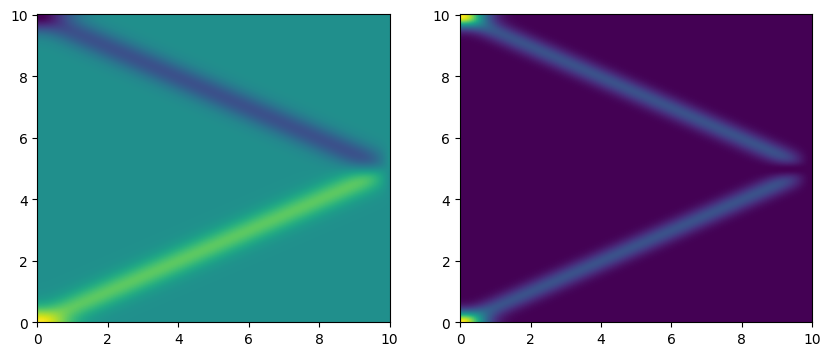

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=wave.get_grid_extents())
ax2.imshow(wave.Y**2, aspect='auto', origin='lower', extent=wave.get_grid_extents())
plt.show()

In [75]:
problem = HProblem1D(
    dt= 0.01,
    dx= 0.05,
    L= 10,
    f= (lambda x: np.exp(-(x - 5)**2)),
    g= (lambda x: 0),
    u= 2
)
params = problem.dict()
T = 1000

def task(left_free: bool):
    params['left_free'] = left_free
    wave = Wave1D(**params)
    wave.run(T)
    return wave.Y

with Pool(cpu_count()) as executor:
    solutions = executor.map(task, (False, True))

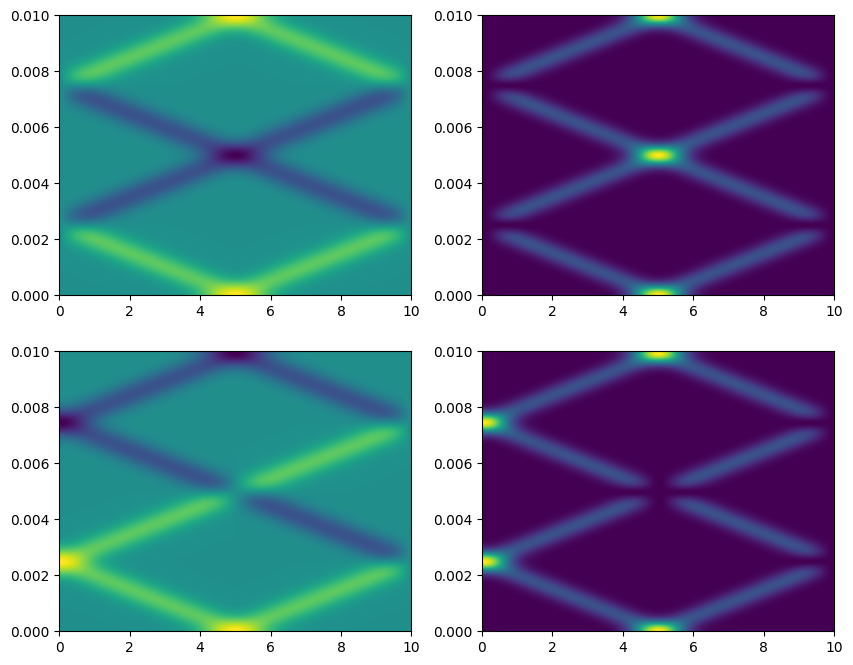

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, Y in enumerate(solutions):
    axs[i][0].imshow(Y, aspect='auto', origin='lower', extent=problem.get_grid_extents())
    axs[i][1].imshow(Y**2, aspect='auto', origin='lower', extent=problem.get_grid_extents())
plt.show()

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
camera = Camera(fig)
for j in range(T):
    for i, Y in enumerate(solutions):
        axs[i].plot(problem.x, Y[j], 'C0-')
    camera.snap()
show(camera.animate(interval=5)) 

In [116]:
c = 1
v = 0.9
x0 = 2
gamma = 1/np.sqrt(1 - (v/c)**2)
lamb = 1
wave = Wave1D(c, 10, 0.05, 0.01, lambda x: np.tanh(gamma*(x - x0)), lambda x: -gamma*v/np.cosh(gamma*(x - x0))**2, h= lambda t, x, y: lamb*y*(1 - y**2))

camera = Camera(plt.gcf())
for _ in range(5000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

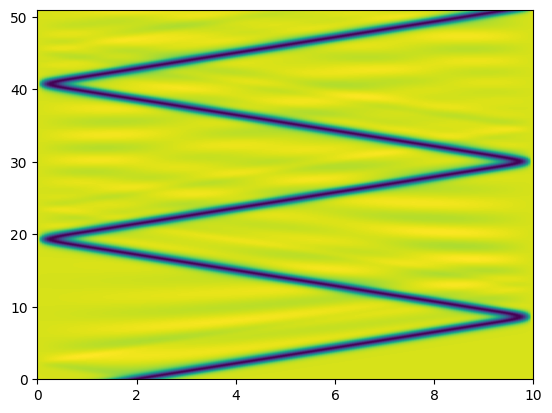

In [117]:
plt.imshow(wave.Y**2, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

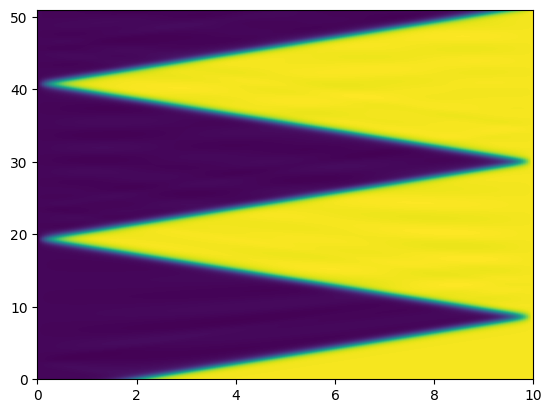

In [118]:
plt.imshow(wave.Y, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))